In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('raw_data.csv', skiprows=2)

# Ensure the timestamp column is numeric
df['lsl_timestamp'] = pd.to_numeric(df['lsl_timestamp'], errors='coerce')

# Find the index of the row where the timestamp is closest to the target value
target_timestamp = 926504.4059599
closest_index = (df['lsl_timestamp'] - target_timestamp).abs().idxmin()

# Define the time window in seconds
time_window = 0.5

# Find the end timestamp of the window
end_timestamp = target_timestamp + time_window

# Extract the window of values from the 'P3' column
window_df = df[(df['lsl_timestamp'] >= target_timestamp) & (df['lsl_timestamp'] <= end_timestamp)]

# Compute the relative time within the window
window_df['relative_time'] = window_df['lsl_timestamp'] - target_timestamp

# Print the extracted window with relative time
#print(window_df[['lsl_timestamp', 'P3', 'relative_time']])
real_eeg_signal=window_df[['P3','relative_time']]
print(real_eeg_signal)

               P3  relative_time
15417  365.645050       0.008262
15418  369.710754       0.008264
15419  359.636993       0.008265
15420  373.456268       0.008267
15421  348.807556       0.008268
...           ...            ...
15565  372.562714       0.487272
15566  363.992462       0.487274
15567  381.278198       0.487275
15568  367.452789       0.487277
15569  366.252319       0.487279

[153 rows x 2 columns]


<ipython-input-37-8049b8ce5158>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



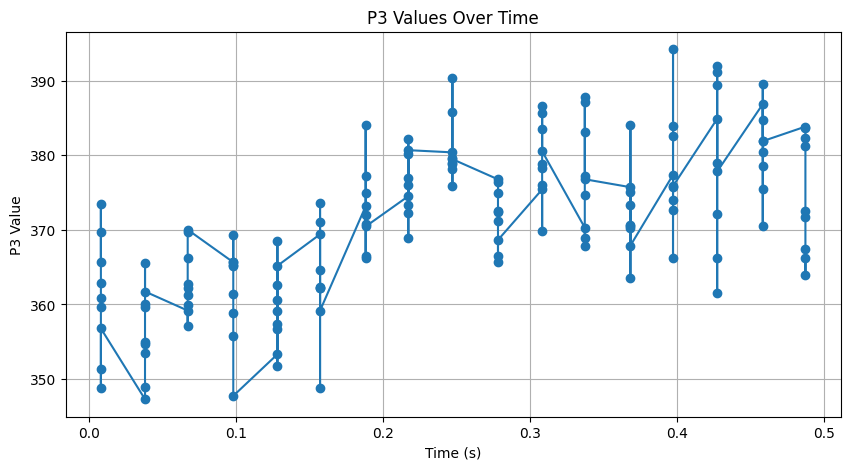

In [ ]:
import matplotlib.pyplot as plt

# Plot the 'P3' values with relative time as the x-axis
plt.figure(figsize=(10, 5))
plt.plot(window_df['relative_time'], window_df['P3'], marker='o')
plt.xlabel('Time (s)')
plt.ylabel('P3 Value')
plt.title('P3 Values Over Time')
plt.grid(True)
plt.show()

In [ ]:
import numba
import numpy as np
from numpy.random import random as rand
from neurolib.models.model import Model
from neurolib.optimize.evolution import Evolution
from neurolib.utils.parameterSpace import ParameterSpace

class EEGModel(Model):
    state_vars = ["eeg_signal"]
    default_output = "eeg_signal"
    init_vars = ["eeg_init"]
    params = dict(tau=10, K=1e-2, dt=1e-1, duration=100, stimulus_amplitude=1.0)

    def __init__(self, Cmat=np.zeros((1,1)), stimulus=np.zeros(1000)):
        self.params['Cmat'] = Cmat
        self.params['stimulus'] = stimulus
        super().__init__(self.timeIntegration, self.params)

    def timeIntegration(self, p):
        p['N'] = p['Cmat'].shape[0]  # number of nodes
        t = np.arange(1, p['duration'] / p['dt'] + 1)  # holds time steps
        eeg_signal = np.ndarray((p['N'], len(t) + 1))  # holds variable eeg_signal
        # either use predefined initial conditions or random ones
        eeg_signal[:, :1] = p['eeg_init'] if 'eeg_init' in p else rand((p['N'], 1))
        return njit_integrate(eeg_signal, t, p['tau'], p['K'], p['N'], p['Cmat'], p['dt'], p['stimulus'], p['stimulus_amplitude'])

@numba.njit
def njit_integrate(eeg_signal, t, tau, K, N, Cmat, dt, stimulus, stimulus_amplitude):
    for i in range(1, 1 + len(t)):  # loop over time
        inp = Cmat.dot(eeg_signal[:, i-1]) + stimulus_amplitude * stimulus[i-1]  # input vector with stimulus
        for n in range(N):  # loop over nodes
            eeg_signal[n, i] = eeg_signal[n, i-1] + (- eeg_signal[n, i-1] / tau + K * inp[n]) * dt  # model equations
    return t, eeg_signal

def evalFunction(individual, square_signal, real_eeg_signal):
    # Convert the individual to a connectivity matrix
    Cmat = np.array(individual).reshape((n_nodes, n_nodes))

    # Create an instance of the EEGModel with the current Cmat
    model = EEGModel(Cmat=Cmat, stimulus=square_signal)

    # Run the model simulation
    model.run()

    # Access the generated EEG signal
    simulated_eeg_signal = model.output

    # Calculate the fitness based on the difference between the simulated and real EEG signals
    fitness = -np.mean((simulated_eeg_signal - real_eeg_signal) ** 2)

    return fitness,

# Define the parameter space for the connectivity matrix
n_nodes = 10  # Number of nodes in the network
parameter_values = [(0, 1)] * (n_nodes * n_nodes)  # Define bounds for each element in the connectivity matrix
parameterSpace = ParameterSpace(['Cmat'], [parameter_values])

# Define the square wave stimulus
duration = 1000  # duration in time steps
square_signal = np.zeros(duration)
square_signal[100:200] = 1  # a square pulse between timesteps 100 and 200
square_signal[400:500] = 1  # another square pulse between timesteps 400 and 500

# Define other parameters for the evolutionary algorithm
weightList = [-1.0]  # Minimize the fitness
POP_SIZE = 20
NGEN = 10

# Create an instance of the Evolution class
evolution = Evolution(
    evalFunction=lambda individual: evalFunction(individual, square_signal=square_signal, real_eeg_signal=real_eeg_signal),
    parameterSpace=parameterSpace,
    weightList=weightList,
    POP_SIZE=POP_SIZE,
    NGEN=NGEN
)

evolution.run()


MainProcess root INFO     Assuming parameter kind "grid"
MainProcess root INFO     Trajectory Name: results-2024-04-11-18H-36M-05S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2024-04-11-18H-36M-05S
MainProcess root INFO     Number of cores: 2
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning:

A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning:

A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that cl

TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

In [ ]:
import numba
import numpy as np
from numpy.random import random as rand
from neurolib.models.model import Model
from neurolib.optimize.evolution import Evolution
from neurolib.utils.parameterSpace import ParameterSpace

class EEGModel(Model):
    state_vars = ["eeg_signal"]
    default_output = "eeg_signal"
    init_vars = ["eeg_init"]
    params = dict(tau=10, K=1e-2, dt=1e-1, duration=100, stimulus_amplitude=1.0)

    def __init__(self, stimulus=np.zeros(1000), Cmat=np.zeros((1,1))):
        self.params['stimulus'] = stimulus
        self.params['Cmat'] = Cmat
        super().__init__(self.timeIntegration, self.params)

    def timeIntegration(self, p):
        p['N'] = p['Cmat'].shape[0]  # number of nodes
        t = np.arange(1, p['duration'] / p['dt'] + 1)  # holds time steps
        eeg_signal = np.ndarray((p['N'], len(t) + 1))  # holds variable eeg_signal
        # either use predefined initial conditions or random ones
        eeg_signal[:, :1] = p['eeg_init'] if 'eeg_init' in p else rand((p['N'], 1))
        return njit_integrate(eeg_signal, t, p['tau'], p['K'], p['N'], p['Cmat'], p['dt'], p['stimulus'], p['stimulus_amplitude'])

@numba.njit
def njit_integrate(eeg_signal, t, tau, K, N, Cmat, dt, stimulus, stimulus_amplitude):
    for i in range(1, 1 + len(t)):  # loop over time
        inp = Cmat.dot(eeg_signal[:, i-1]) + stimulus_amplitude * stimulus[i-1]  # input vector with stimulus
        for n in range(N):  # loop over nodes
            eeg_signal[n, i] = eeg_signal[n, i-1] + (- eeg_signal[n, i-1] / tau + K * inp[n]) * dt  # model equations
    return t, eeg_signal

def evalFunction(individual, square_signal, real_eeg_signal, Cmat):
    # Create an instance of the EEGModel with the predefined Cmat
    model = EEGModel(stimulus=square_signal, Cmat=Cmat)

    # Run the model simulation
    model.run()

    # Access the generated EEG signal
    simulated_eeg_signal = model.output

    # Calculate the fitness based on the difference between the simulated and real EEG signals
    fitness = -np.mean((simulated_eeg_signal - real_eeg_signal) ** 2)

    return fitness,

# Define the square wave stimulus
duration = 1000  # duration in time steps
square_signal = np.zeros(duration)
square_signal[100:200] = 1  # a square pulse between timesteps 100 and 200
square_signal[400:500] = 1  # another square pulse between timesteps 400 and 500

# Define other parameters for the evolutionary algorithm
weightList = [-1.0]  # Minimize the fitness
POP_SIZE = 20
NGEN = 10

# Predefine the connectivity matrix (replace this with your learned matrix)
Cmat = np.random.rand(10, 10)  # Example: random 10x10 matrix


evolution.run()


AssertionError: Parameters must be a dict, if no values are given in `parameterValues`

In [ ]:
class EEGModel(Model):
    state_vars = ["eeg_signal"]
    default_output = "eeg_signal"
    init_vars = ["eeg_init"]
    params = dict(tau=10, K=1e-2, dt=1e-1, duration=100, stimulus_amplitude=1.0)

    def __init__(self, stimulus=np.zeros(1000), Cmat=np.zeros((1,1))):
        self.params['stimulus'] = stimulus
        self.params['Cmat'] = Cmat
        super().__init__(self.timeIntegration, self.params)

    def timeIntegration(self, p):
        p['N'] = p['Cmat'].shape[0]  # number of nodes
        t = np.arange(0, p['duration'], p['dt'])  # holds time steps
        eeg_signal = np.zeros((p['N'], len(t)))  # holds variable eeg_signal
        # either use predefined initial conditions or random ones
        eeg_signal[:, 0] = p['eeg_init'] if 'eeg_init' in p else rand(p['N'])
        t, eeg_signal = self.njit_integrate(eeg_signal, t, p['tau'], p['K'], p['N'], p['Cmat'], p['dt'], p['stimulus'], p['stimulus_amplitude'])
        # Return the timestamps and eeg_signal as output
        return {"t": t, "eeg_signal": eeg_signal}

    @staticmethod
    @numba.njit
    def njit_integrate(eeg_signal, t, tau, K, N, Cmat, dt, stimulus, stimulus_amplitude):
        for i in range(1, len(t)):  # loop over time
            inp = Cmat.dot(eeg_signal[:, i-1]) + stimulus_amplitude * stimulus[i-1]  # input vector with stimulus
            for n in range(N):  # loop over nodes
                eeg_signal[n, i] = eeg_signal[n, i-1] + (- eeg_signal[n, i-1] / tau + K * inp[n]) * dt  # model equations
        return t, eeg_signal

def generate_eeg_signal(Cmat, stimulus, electrode_index=0):
    # Create an instance of the EEGModel with the given Cmat and stimulus
    model = EEGModel(Cmat=Cmat, stimulus=stimulus)
    # Run the model simulation
    model.run()
    # Return the generated EEG signal for the specified electrode and the corresponding timestamps
    timestamps, eeg_signal = model.output
    return timestamps, eeg_signal[electrode_index, :]

def compute_error(simulated_signal, real_signal):
    # Compute the mean squared error between the simulated and real signals
    return np.mean((simulated_signal - real_signal) ** 2)

def update_Cmat(Cmat, learning_rate, gradient):
    # Update the connectivity matrix based on the gradient and learning rate
    return Cmat - learning_rate * gradient

def gradient_descent(real_signal, stimulus, learning_rate, max_iterations, n_nodes):
    # Initialize the connectivity matrix with random values
    Cmat = np.random.rand(n_nodes, n_nodes)

    for iteration in range(max_iterations):
        # Generate a simulated EEG signal with the current Cmat
        simulated_signal = generate_eeg_signal(Cmat, stimulus)
        # Compute the error between the simulated and real signals
        error = compute_error(simulated_signal, real_signal)
        # Placeholder for the actual gradient computation
        # This should be replaced with the correct gradient calculation
        gradient = np.random.rand(n_nodes, n_nodes)  # Random gradient for demonstration
        # Update the connectivity matrix based on the gradient
        Cmat = update_Cmat(Cmat, learning_rate, gradient)
        # Print the error for monitoring
        print(f"Iteration {iteration + 1}, Error: {error}")

    return Cmat

# Define the real EEG signal and stimulus (replace these with your actual data)
real_signal = np.random.rand(1000)  # Placeholder for the real EEG signal
stimulus = np.zeros(1000)
stimulus[100:200] = 1
stimulus[400:500] = 1

# Run the gradient descent algorithm to learn the connectivity matrix
learned_Cmat = gradient_descent(real_signal, stimulus, learning_rate=0.01, max_iterations=100, n_nodes=10)

# Use the learned connectivity matrix to run the EEGModel
final_simulated_signal = generate_eeg_signal(learned_Cmat, stimulus)

MainProcess root INFO     Noname: Model initialized.


ValueError: too many values to unpack (expected 2)

In [ ]:
print(len(final_simulated_signal[0]))

1000


In [ ]:
class EEGModel(Model):
    state_vars = ["eeg_signal"]
    default_output = "eeg_signal"
    init_vars = ["eeg_init"]
    params = dict(tau=10, K=1e-2, dt=1e-1, duration=100, stimulus_amplitude=1.0)

    def __init__(self, stimulus=np.zeros(1000), Cmat=np.zeros((1,1))):
        self.params['stimulus'] = stimulus
        self.params['Cmat'] = Cmat
        super().__init__(self.timeIntegration, self.params)

    def timeIntegration(self, p):
        p['N'] = p['Cmat'].shape[0]  # number of nodes
        t = np.arange(0, p['duration'], p['dt'])  # holds time steps
        eeg_signal = np.zeros((p['N'], len(t)))  # holds variable eeg_signal
        # either use predefined initial conditions or random ones
        eeg_signal[:, 0] = p['eeg_init'] if 'eeg_init' in p else rand(p['N'])
        t, eeg_signal = self.njit_integrate(eeg_signal, t, p['tau'], p['K'], p['N'], p['Cmat'], p['dt'], p['stimulus'], p['stimulus_amplitude'])
        # Return the eeg_signal as output
        return eeg_signal

    @staticmethod
    @numba.njit
    def njit_integrate(eeg_signal, t, tau, K, N, Cmat, dt, stimulus, stimulus_amplitude):
        for i in range(1, len(t)):  # loop over time
            inp = Cmat.dot(eeg_signal[:, i-1]) + stimulus_amplitude * stimulus[i-1]  # input vector with stimulus
            for n in range(N):  # loop over nodes
                eeg_signal[n, i] = eeg_signal[n, i-1] + (- eeg_signal[n, i-1] / tau + K * inp[n]) * dt  # model equations
        return t, eeg_signal

def generate_eeg_signal(Cmat, stimulus, electrode_index=0):
    # Create an instance of the EEGModel with the given Cmat and stimulus
    model = EEGModel(Cmat=Cmat, stimulus=stimulus)
    # Run the model simulation
    model.run()
    # Return the generated EEG signal
    return model.output

def compute_error(simulated_signal, real_signal):
    # Find the length of the longer array
    max_length = max(len(simulated_signal), len(real_signal))
    # Pad the shorter array with zeros
    if len(simulated_signal) < max_length:
        simulated_signal = np.pad(simulated_signal, (0, max_length - len(simulated_signal)), 'constant')
    elif len(real_signal) < max_length:
        real_signal = np.pad(real_signal, (0, max_length - len(real_signal)), 'constant')
    # Compute the mean squared error between the simulated and real signals
    return np.mean((simulated_signal - real_signal) ** 2)

def update_Cmat(Cmat, learning_rate, gradient):
    # Update the connectivity matrix based on the gradient and learning rate
    return Cmat - learning_rate * gradient

def gradient_descent(real_signal, stimulus, learning_rate, max_iterations, n_nodes):
    # Initialize the connectivity matrix with random values
    Cmat = np.random.rand(n_nodes, n_nodes)

    for iteration in range(max_iterations):
        # Generate a simulated EEG signal with the current Cmat
        simulated_signal = generate_eeg_signal(Cmat, stimulus)
        # Compute the error between the simulated and real signals
        error = compute_error(simulated_signal, real_signal)
        # Placeholder for the actual gradient computation
        # This should be replaced with the correct gradient calculation
        gradient = np.random.rand(n_nodes, n_nodes)  # Random gradient for demonstration
        # Update the connectivity matrix based on the gradient
        Cmat = update_Cmat(Cmat, learning_rate, gradient)
        # Print the error for monitoring
        print(f"Iteration {iteration + 1}, Error: {error}")

    return Cmat

# Define the real EEG signal and stimulus (replace these with your actual data)
real_signal = np.random.rand(1000)  # Placeholder for the real EEG signal
stimulus = np.zeros(1000)
stimulus[100:200] = 1
stimulus[400:500] = 1

# Run the gradient descent algorithm to learn the connectivity matrix
learned_Cmat = gradient_descent(real_signal, stimulus, learning_rate=0.01, max_iterations=100, n_nodes=10)

# Use the learned connectivity matrix to run the EEGModel
final_simulated_signal = generate_eeg_signal(learned_Cmat, stimulus)



MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initia

Iteration 1, Error: 0.20849542448628972
Iteration 2, Error: 0.20585062732644882
Iteration 3, Error: 0.1992372467876756
Iteration 4, Error: 0.2116440367072769
Iteration 5, Error: 0.2076640014023485
Iteration 6, Error: 0.21836289866654968
Iteration 7, Error: 0.21811435893949657
Iteration 8, Error: 0.214430983537506
Iteration 9, Error: 0.21641235591307076
Iteration 10, Error: 0.21168192742701297
Iteration 11, Error: 0.219073801311415
Iteration 12, Error: 0.21679932313469033
Iteration 13, Error: 0.21339025871743514
Iteration 14, Error: 0.22771785373406253
Iteration 15, Error: 0.21479846406469183
Iteration 16, Error: 0.22103624834053034
Iteration 17, Error: 0.21373501588118976
Iteration 18, Error: 0.22869268009840396
Iteration 19, Error: 0.2449030694061017
Iteration 20, Error: 0.2231926731222283
Iteration 21, Error: 0.23085214626857078
Iteration 22, Error: 0.22353643632976333
Iteration 23, Error: 0.2235217110566145
Iteration 24, Error: 0.22374751966494907


MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initia

Iteration 25, Error: 0.22090280222837436
Iteration 26, Error: 0.22322117807428077
Iteration 27, Error: 0.23479408522698417
Iteration 28, Error: 0.22946643425238553
Iteration 29, Error: 0.22932022135163502
Iteration 30, Error: 0.22907869141141501
Iteration 31, Error: 0.2270667902047293
Iteration 32, Error: 0.23070252496067062
Iteration 33, Error: 0.22891655564282432
Iteration 34, Error: 0.2255347009821093
Iteration 35, Error: 0.2342882635484167
Iteration 36, Error: 0.2456473606796485
Iteration 37, Error: 0.2572395792686428
Iteration 38, Error: 0.24573913462997252
Iteration 39, Error: 0.2524368584026562
Iteration 40, Error: 0.25089546538302476
Iteration 41, Error: 0.23573060455441086
Iteration 42, Error: 0.23160662613629365
Iteration 43, Error: 0.2383260331756056
Iteration 44, Error: 0.23535919778893205
Iteration 45, Error: 0.23892896694749954
Iteration 46, Error: 0.24995450976613368
Iteration 47, Error: 0.24030486286304356
Iteration 48, Error: 0.24857524293499375
Iteration 49, Error: 0.

MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initia

Iteration 60, Error: 0.2580923419659929
Iteration 61, Error: 0.24664619377121205
Iteration 62, Error: 0.2562951182254181
Iteration 63, Error: 0.24560528850875318
Iteration 64, Error: 0.26597059033074766
Iteration 65, Error: 0.2535314395860356
Iteration 66, Error: 0.24849563431115967
Iteration 67, Error: 0.2484787154059851
Iteration 68, Error: 0.24895013516602432
Iteration 69, Error: 0.24401173175288163
Iteration 70, Error: 0.24877273399361724
Iteration 71, Error: 0.2796499737635726
Iteration 72, Error: 0.2569562298015935
Iteration 73, Error: 0.2487958239532584
Iteration 74, Error: 0.2506856732303915
Iteration 75, Error: 0.24965174292431547
Iteration 76, Error: 0.25850813565308783
Iteration 77, Error: 0.27390044802935887
Iteration 78, Error: 0.25701546008304754
Iteration 79, Error: 0.2646469223728081
Iteration 80, Error: 0.25198258033680676
Iteration 81, Error: 0.26488848656329894
Iteration 82, Error: 0.25871349164212554
Iteration 83, Error: 0.28251883908875053
Iteration 84, Error: 0.26

MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.
MainProcess root INFO     Noname: Model initialized.


Iteration 96, Error: 0.25457925617959776
Iteration 97, Error: 0.2716126881344129
Iteration 98, Error: 0.28431898512281123
Iteration 99, Error: 0.26167646152474844
Iteration 100, Error: 0.26015116717180603


In [ ]:
len(final_simulated_signal)

999